# Volume 4: River Crossing
    Adam Ward
    Math 438
    2/19/25

In [75]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate
from scipy.optimize import root, minimize
from scipy.integrate import quad

plt.rcParams["figure.figsize"] = (10, 6)

# Problem 1
Assume that the current is given by $c(x) = −
\frac{7}{10} (x^2 − 1)$. (This function assumes, for example, that the current is faster near the center of the river.) Write a Python
function that accepts as arguments a function $y$, its derivative $y'$, and an $x$-value, and returns $L(x, y(x), y'(x))$ (where $T[y]=\int^1_{-1} L(x,y(x),y'(x))dx$ Use that function to defune a second
function that numerically computes $T[y]$ for a given path $y(x)$.

In [26]:
def lagrange(x, y, yp):
    # define the c function
    c = lambda x: -(.7) * (x**2 - 1)

    # define the alpha function
    alpha = lambda x: (1 - c(x)**2)**(-.5)

    # now return the function value at x
    return alpha(x) * np.sqrt(1 + (alpha(x) * yp(x))**2) - (alpha(x)**2) * c(x) * yp(x)

def compute_T(y, yp):    
    # return the integral of the Lagrange function
    return quad(lagrange, -1, 1, args=(y, yp,))[0]

# Problem 2

Let y(x) be the straight-line path between A = (−1, 0) and B = (1, 5). Numerically calculate T[y] to get an upper bound on the minimum time required to cross from A to
B. Using (18.2), find a lower bound on the minimum time required to cross.

In [47]:
# initialize y and yp
y = lambda x: (5/2) * (x + 1)
yp = lambda x: 5/2

# perform the computation for the upper bound
T = compute_T(y, yp)

# get the lower bound by minimizing the secant function, which is >= 1 for all x (help from Matt W here!!)
# thus the integral from -1 to 1 of 1 is 2
print("Upper Bound:", T)
print("Lower Bound:", 2)

Upper Bound: 3.8770820491384126
Lower Bound: 2


# Problem 3

Numerically solve the Euler-Lagrange equation (18.4), using c(x) = −
7
10 (x
2 − 1)
and α = (1 − c
2
)
−1/2
, and y(−1) = 0, y(1) = 5.
Hint: Since this boundary value problem is defined over the doimain [−1, 1], it is easy to
solve using the pseudospectral method. Begin by replacing each d
dx with the pseudospectral
differentiation matrix D. Then impose the boundary conditions and solve.

In [85]:
# define the helper cheb function
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0, N, N+1))
    x.shape = (N+1, 1)
    lin = np.linspace(0, N, N+1)
    lin.shape = (N+1, 1)
    
    c = np.ones((N+1, 1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # Broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T, axis=0))
    x.shape = (N+1,)
    
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D[::-1, ::-1], x[::-1]

In [86]:
def EL_condition(y, c, alpha): 
    # force the boundaries to be those given in the problem
    D, cheby_x = cheb(8)
    F_init = y(cheby_x)

    def F(Y):
        out = D @ (alpha(cheby_x)**3 * (D @ Y) * ((1 + (alpha(cheby_x) * (D @ Y))**2)**(-.5)) - alpha(cheby_x)**2 * c(cheby_x))
        out[0] = Y[0]
        out[-1] = Y[-1] - 5     # make the endpoints work
        return out  # Newtons Method updates Y until the output is all 0's.

    guess = np.ones_like(cheby_x)   # Your guess is same size as the cheb(N) output
    solution = root(F, F_init).x     # find the solution

    return cheby_x, solution, D

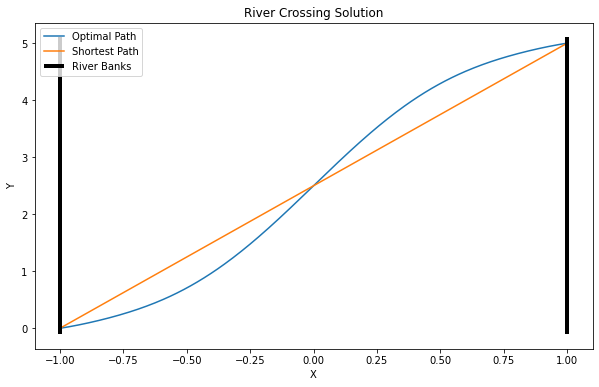

In [87]:
# initialize y and yp
y = lambda x: (5/2) * (x + 1)

# define the c function
c = lambda x: -(.7) * (x**2 - 1)

# define the alpha function
alpha = lambda x: (1 - c(x)**2)**(-.5)

# get the solution using the E-L conditions
xs, y_approx, _ = EL_condition(y, c, alpha)

# interpolate the solution to make it smooth
interp = barycentric_interpolate(xs, y_approx, np.linspace(-1, 1, 300))

# plot the solutions
plt.plot(np.linspace(-1, 1, 300), interp, label="Optimal Path")
plt.plot(xs, y(xs), label="Shortest Path")
plt.vlines([-1, 1], -.1, 5.1, linewidth=4, colors='black', label="River Banks")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("River Crossing Solution")
plt.legend()
plt.show()

# Problem 4

Plot the angle at which the boat should be pointed at each $x$-coordinate. (Hint: use Equation 1.1; see Figure 1.3. Note that the angle the boat should be steered is NOT described by the tangent vector to the trjaectory)

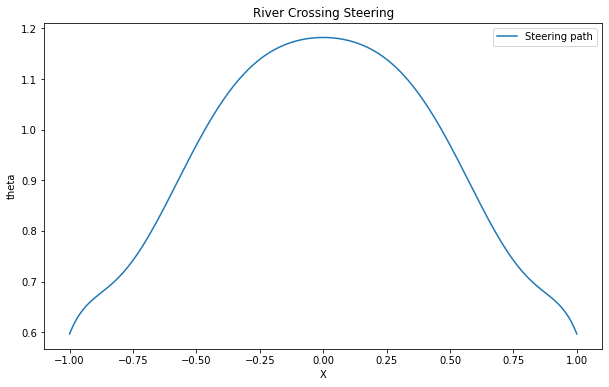

In [93]:
def boat_angle(y, c, alpha):
    # get the y path
    xs, y_path, D = EL_condition(y, c, alpha)
    y_prime = D @ y_path
    
    def F(theta):
        return c(xs) * (1/np.cos(theta)) + np.tan(theta) - y_prime

    # do the inverse of 19.1 (solved for theta(x)) to get the steering angles
    theta = root(F, np.ones_like(xs)).x

    # interpolate the solution to make it smooth
    interp = barycentric_interpolate(xs, theta, np.linspace(-1, 1, 300))

    # convert to radians
    # theta_rad = np.deg2rad(interp)

    # plot the theta over x
    plt.plot(np.linspace(-1, 1, 300), interp, label="Steering path")
    plt.xlabel("X")
    plt.ylabel("theta")
    plt.title("River Crossing Steering")
    plt.legend()
    plt.show()

boat_angle(y, c, alpha)